# **P4**: DECISION TREES 
### Total points: 38

Decision trees are a supervised learning algorithm used for both classification and regression tasks. For this assignment we are going to take a look at classification. We can use decision trees for issues where we have numerical but also categorical input and target features. The decision tree algorithm you will be implementing is based off the *ID3* algorithm as described in chapter 3 of the book "Machine Learning" by Tom Mitchell, sections **3.1-3.4**.  See Canvas for a link to the PDF.

After building our own *ID3* tree, we will then use scikit-learn to explore decision trees with numerical features. Besides working with data containing both categorical and numeric features, this assignment will give us a chance to study the following topics:

* Dealing with a more realistic data set. The Iris dataset is useful to get started, as it just works out of the box, but real world datasets will almost always be a lot messier. Having to do some preprocessing to end up with a usable representation is extremely common.
* Working with dataframes. `pandas` is a very popular Python library for Data Science that enables you to perform database-like operations on large datasets with great performance. It is a very useful tool to add to your arsenal.
* Analysing the results of an algorithm. The results you get when you have (correctly) implemented the algorithm might surprise you. Trying to set up hypotheses about why this is the case and what you could do to improve / prevent / fix this, is a key skill in applying machine learning on real problems.

# Pandas Warmup

Before we start with the actual assignment, we will introduce `pandas` through a set of small exercises. For this we will use the book by the creator of `pandas`: [Python for Data Analysis](https://bedford-computing.co.uk/learning/wp-content/uploads/2015/10/Python-for-Data-Analysis.pdf). You won't have to read the whole book, but it will serve as a useful reference while you figure out how certain operations are done in `pandas`.

Below each of the exercises is a set of assertions that test whether you gave the correct answer.  Let's first import Pandas and remove any deprecation warnings.

In [186]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore")

# import Pandas
import pandas as pd

### Series [2 pts]

Start by reading Python for Data Analysis pages 111-115 on Series.

Create a `Series`-object named `earnings` containing the following *figures* and using the *sources* as its index.

In [187]:
earnings_sources = ["sales", "ads", "subscriptions", "donations"]
earnings_figures = [39041, 8702, 13200, 292]

### YOUR SOLUTION HERE
earnings = pd.Series(earnings_figures, earnings_sources)


In [188]:
assert type(earnings) is pd.Series, "Income has to be a Series"
assert list(earnings.index) == ["sales", "ads", "subscriptions", "donations"]
assert list(earnings) == [39041, 8702, 13200, 292]

Create a `Series`-object named `expenses` using the same format as `earning` with the expenses *figures*. Then create another `Series`-object named `profit` with the profit figures for each category (earnings minus expenses). Lastly, create a variable `total_profit` containing the summed total of `profit`.

In [189]:
expenses_sources = ["ads", "sales", "donations", "subscriptions"]
expenses_figures = [4713, 24282, 0, 3302]

### YOUR SOLUTION HERE
expenses = pd.Series(expenses_figures, expenses_sources)
profit = earnings - expenses

total_profit = sum(profit)

In [190]:
assert type(expenses) is pd.Series
assert type(profit) is pd.Series
float(total_profit)
assert list(profit) == [3989, 292, 14759, 9898]
assert total_profit == 28938

### DataFrames [3 pts]

Next read Python for Data Analysis pages 115-120 on DataFrames.

Create a `DataFrame` named `skittles` with the *columns* `amount` and `rating`, using the different colors as the *index*.

|&nbsp;      | amount | rating |
|------------|--------|--------|
| **red**    | 7      | 3      |
| **green**  | 4      | 4      |
| **blue**   | 6      | 2      |
| **purple** | 5      | 4      |
| **pink**   | 6      | 3.5    |

In [191]:
from pandas import DataFrame

### YOUR SOLUTION HERE
cols = {"amount": [7, 4, 6, 5, 6], "rating": [3, 4, 2, 4, 3.5]}
skittles = pd.DataFrame(cols, ["red", "green", "blue", "purple", "pink"])


In [192]:
assert type(skittles) is DataFrame
assert list(skittles.index) == ["red", "green", "blue", "purple", "pink"]
assert list(skittles.columns) == ["amount", "rating"]
assert skittles.loc["red", "amount"] == 7
assert skittles.loc["blue", "rating"] == 2

Calculate the average _rating_ of all the skittles and store it in a variable called `skittles_average`.

In [193]:
### YOUR SOLUTION HERE
from numpy import mean

skittles_average = mean(skittles.rating)

In [194]:
float(skittles_average)
assert skittles_average == 3.3

Add a new column to the skittles `DataFrame` called `score`. The score of a color is equal to `amount * rating`.

In [195]:
### YOUR SOLUTION HERE
score = skittles.amount * skittles.rating
skittles["score"] = score

In [196]:
assert "score" in skittles

### (Re)Indexing [2 pts]

Read Python for Data Analysis pages 122-128, Reindexing, Dropping entries, and "Indexing, selection, and filtering".

Reindex the given `DataFrame` for columns 'a', 'c', and 'e', using indices 10, 20, 50, 60 and store the result in the same `frame` variable.

In [197]:
import numpy as np

frame = DataFrame(np.arange(6 * 7.).reshape((6, 7)), index=[10, 20, 30, 40, 50, 60], columns=list('abcdefg'))

### YOUR SOLUTION HERE
frame = frame.reindex([10, 'b', 20, 'd', 50, 'f', 'g'], axis='columns')

In [198]:
assert type(frame) == DataFrame

Replace all values in the data frame that are *divisible by 3* with the value *0*, and once again store the result in the `frame` variable.

In [199]:
frame = DataFrame(np.arange(6 * 7.).reshape((6, 7)), index=[10, 20, 30, 40, 50, 60], columns=list('abcdefg'))

### YOUR SOLUTION HERE
frame[frame % 3 == 0] = 0

In [200]:
assert type(frame) == DataFrame

This completes this `pandas` introduction. Now lets move on to the actual decision tree assignment.

# Predicting heart disease 

The data set we will be using for this assignment contains heart disease diagnosis results from 4 different hospitals. The data set can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/). Download the dataset.

Lets start by looking at the [heart-disease.names](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names) file, which contains a description of the data set. The file also gives an explanation for the values of the different variables, so when our tree is complete we can interpret the decision rules created by the algorithm. 

Some variables included here, like *#9 cp: chest pain type*, with 4 labels for different types of chest pain, are clearly categorical. Then there are variables like *#12 chol: serum cholestoral in mg/dl*, containing the concentration of cholesterol, an obvious numeric value. The ability to handle both of these types of data is something not many other machine learning algorithms can do effectively, so in theory a decision tree should be perfect for this data.

### Taking a first look [2 pts]

Start by loading the four `processed.X.data` files into a *Pandas DataFrame* with the function `pd.read_csv`. Do not forget to manually set the names of the columns! You can find these names listed in the [heart-disease.names](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names) file. 

Create a list `data` that contains these four dataframes and print the dataset. You should see a couple of unexpected values pop up, which probably indicate a missing value. The file describing the data sets states that missing values are indicated by $-9.0$, but this doesn't seem to be the case. 


In [201]:
file_names = ['processed.cleveland.data', 'processed.hungarian.data', 'processed.switzerland.data','processed.va.data']
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
data = []

# Concatenate the file names with this prefix to read them directly into this notebook
# pd.read_csv can then take the whole URL as an argument
url_prefix = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/"

### YOUR SOLUTION HERE
for i in range(4):
    data.append(pd.read_csv(url_prefix + file_names[i], names=column_names))

print(data[0])

      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca thal  num  
0      3.0  0.0  6.0   

Lets inspect the scope of this problem by writing the `count_missing` function, which should count the number of missing elements for each feature / column of a data set. The function should thus return a *Series* of missing counts, one count for each column in the data set. We have provided you with the code to print some statistics.

In [202]:
def count_missing(df):
    ### YOUR SOLUTION HERE
  
    c = df.apply(pd.value_counts).loc["?"]
    return c
    

for i in range(len(data)):
    print(f'Filename: {file_names[i]}')
    print(f'Rows: {len(data[i])}')
    
    # The following code makes sure that we print horizontally and not vertically
    print(f'Missing per column: \n{count_missing(data[i]).to_frame().T}')
    print()

Filename: processed.cleveland.data
Rows: 303
Missing per column: 
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
?  NaN  NaN NaN       NaN   NaN  NaN      NaN      NaN    NaN      NaN    NaN   

    ca  thal  num  
?  4.0   2.0  NaN  

Filename: processed.hungarian.data
Rows: 294
Missing per column: 
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
?  NaN  NaN NaN       1.0  23.0  8.0      1.0      1.0    1.0      NaN  190.0   

      ca   thal  num  
?  291.0  266.0  NaN  

Filename: processed.switzerland.data
Rows: 123
Missing per column: 
   age  sex  cp  trestbps  chol   fbs  restecg  thalach  exang  oldpeak  \
?  NaN  NaN NaN       2.0   NaN  75.0      1.0      1.0    1.0      6.0   

   slope     ca  thal  num  
?   17.0  118.0  52.0  NaN  

Filename: processed.va.data
Rows: 200
Missing per column: 
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
?  NaN  NaN NaN      56.0   7.0  7.0

### Cleaning the data [2 pts]

Looking at the results from the previous step, it seems like the sets from some hospitals are more complete than others. There are different approaches you might take to solve this, like replacing the missing values with the average value for that variable, or handling missing values within the algorithm in a seperate way. For now we will take the simplest approach, discarding any rows that contain missing values. This way we only use the complete patient records from each data set. 

We have concatenated all four DataFrames into a single DataFrame called `df`. Drop any rows containing a missing value. You can use pandas `pd.to_numeric` with keyword `error='coerce'` to easily convert entries to floats. When trying to convert the missing values, the DataFrame will transform these into `NaN` (Not a Number) instead of a float. After you remove the rows with `NaN`, you should end up with about 300 patient records, most of which are from the Cleveland hospital. Each patient has 14 variables, one of which (the 14th variable) is the target variable.

In [203]:
df = pd.concat(data, ignore_index=True)
print(len(df))
### YOUR SOLUTION HERE
df = df.apply(pd.to_numeric, errors="coerce")
df.dropna(inplace=True)
### END HERE
assert len(df) == 299
assert len(df.columns) == 14

target = df.columns[-1]

920


Lets take a look at how how often each label in the target variable actually occurs.

In [204]:
from collections import Counter

Counter(df[target])

Counter({0: 160, 2: 35, 1: 56, 3: 35, 4: 13})

We can see that the number of each of the labels of our target variable differs greatly. While there are 160 labels with the value $0$, we only have 13 labels with value $4$. In virtually all classification tasks, training data that contains different numbers of representatives from each class might result in a classifier that is biased towards the most common class. When applied to a test set that is similarly imbalanced, this classifier yields an optimistic accuracy estimate. In an extreme case, the classifier might assign every single test case to the majority class, thereby trivially achieving an accuracy equal to the proportion of test cases belonging to the majority class!

In the description file ([heart-disease.names](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names)) it says *Value 0: < 50% diameter narrowing* and *Value 1: > 50% diameter narrowing*, but it does not explain all the other values. It might be logical to assume that these are different degrees of narrowing, where $0$ would mean no disease and higher values would mean different levels of disease present. Because the distribution of the different values is so skewed however, for now we will just focus on classifying the difference between a value of $0$  and any of the higher values.

Change the target column to contain a boolean value that is `True` if there is more than $50\%$ narrowing and `False` otherwise. Then print the counts.

In [205]:
### YOUR SOLUTION STATS HERE
df.loc[df[target] == 0, target] = False
df.loc[df[target] > 0, target] = True
### ENDS HERE

Counter(df[target])

Counter({False: 160, True: 139})

# Categorical Decision Trees

If you have not yet read sections **3.1-3.4** of "Machine Learning" by Tom Mitchell, do so now. The entire chapter 3 on Decision Trees is linked on the Canvas homepage.

The main idea of decision trees is to find the feature that contains the most "information" and then split/group the dataset along the rows of this feature that have the same value. This process of finding the "most informative" feature and then splitting is repeated until we arrive at a stopping criterium.

We will implement this process over several steps:
- Generate splits from a given dataset
- Calculate the Shannon entropy; a measure of the amount of information in a given dataset
- Calculate the Information Gain for a given split
- Combine these metrics into an algorithm that creates the Decision Tree

## Splits [3 pts]

Before we can determine which of our features produce the most descriptive split, we must create each split. **A split is a grouping of rows in a dataset by each of the unique values in _one_ of the columns.**

First, we need to determine what unique values are present in a column. Implement a function named `unique_values` that takes a dataframe `df` and a column name `m` and returns a list of the unique values in the given column. Test the function by entering a couple of the column names and see if the outcome is as expected.

In [206]:
def unique_values(df, m):
    ### YOUR SOLUTION HERE

    return df[m].unique()

print(unique_values(df, 'age'))
print(unique_values(df, 'sex'))
print(unique_values(df, 'chol'))

[63. 67. 37. 41. 56. 62. 57. 53. 44. 52. 48. 54. 49. 64. 58. 60. 50. 66.
 43. 40. 69. 59. 42. 55. 61. 65. 71. 51. 46. 45. 39. 68. 47. 34. 35. 29.
 70. 77. 38. 74. 76.]
[1. 0.]
[233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256. 263.
 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226. 247.
 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175. 417.
 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185. 232.
 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 208. 264. 321. 274.
 325. 235. 257. 164. 141. 252. 255. 201. 222. 260. 182. 303. 265. 309.
 307. 249. 186. 341. 183. 407. 217. 288. 220. 209. 227. 261. 174. 281.
 221. 205. 240. 289. 318. 298. 564. 246. 322. 299. 300. 293. 277. 214.
 207. 160. 394. 184. 315. 409. 244. 195. 196. 126. 313. 259. 200. 262.
 215. 228. 193. 271. 210. 327. 149. 295. 306. 178. 237. 218. 223. 242.
 319. 166. 180. 311. 278. 342. 169. 187. 157. 176. 241. 131. 100.]


Now implement a function named `create_split` that takes a dataframe `df` and a column name `m` and returns a dictionary. This dictionary has the *unique column values* as its keys, and the split dataframes as its values. Remember that you just wrote a function for getting the unique keys! Each of the dataframes consist of only data rows that match with the same unique value. Simply put, the data frame rows are "grouped" by each of the different unique values from that column.

*Note:* When adding each of the frames in the dictionary, remove the column that was used to create the split. We have already split it into its different unique values, so the information in that column is now redundant and further splits on this column would not be possible.

You should end up with a dictionary that has a set of rows for each unique value in the given column. Test the function by entering a column name, and see if the outcome is as expected.

In [207]:
def create_split(df, m):
    ### YOUR SOLUTION HERE
    split = dict()
    for attribute_value in unique_values(df, m):
        split[attribute_value] = df.loc[df[m] == attribute_value]
        split[attribute_value].drop(columns=m, inplace=True)
    return split
    
print(create_split(df, 'age')[55])

     sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  slope  \
38   1.0  4.0     132.0  353.0  0.0      0.0    132.0    1.0      1.2    2.0   
123  1.0  4.0     140.0  217.0  0.0      0.0    111.0    1.0      5.6    3.0   
135  0.0  2.0     135.0  250.0  0.0      2.0    161.0    0.0      1.4    2.0   
153  1.0  4.0     160.0  289.0  0.0      2.0    145.0    1.0      0.8    2.0   
208  1.0  2.0     130.0  262.0  0.0      0.0    155.0    0.0      0.0    1.0   
231  0.0  4.0     180.0  327.0  0.0      1.0    117.0    1.0      3.4    2.0   
282  0.0  4.0     128.0  205.0  0.0      1.0    130.0    1.0      2.0    2.0   
291  0.0  2.0     132.0  342.0  0.0      0.0    166.0    0.0      1.2    1.0   

      ca  thal    num  
38   1.0   7.0   True  
123  0.0   7.0   True  
135  0.0   3.0  False  
153  1.0   7.0   True  
208  0.0   3.0  False  
231  0.0   3.0   True  
282  1.0   7.0   True  
291  0.0   3.0  False  


## Entropy [4 pts]
There quite a few different definitions of what entropy is; all of them relate to the notion of chaos / order in a system, but the exact definition strongly depends on the context in which the term is used. Most commonly the term refers to thermodynamic entropy, where it is the describes the number possible configurations a thermodynamic system can have in a specific state. This is related to the idea of a universal entropy, as used in Asimov's classic short story [The Last Question](http://multivax.com/last_question.html). For decision trees we need the information theoretic entropy, or Shannon entropy, which says something about the amount of information contained in a distribution of data. The more ordered or one-sided the distribution is, the less bits we would need on average to express the exact distribution.

We will use this measure of entropy to compare the results of decision tree splits to see which is the "most informative". For the heart disease problem there are now only 2 class labels we are considering, `True` if *vascular narrowing >= 50% diameter* and `False` otherwise. For a 2 class problem, the entropy is defined as:

(3.1) $$\phi(p) = −p\ log_2(p) − (1 − p)\ log_2(1 − p)$$

where $p$ is the ratio between between the labels for class 1 and class 2. 

First, write a `ratio` function to compute $p$. The function should, given a list of boolean values as class labels, return the ratio of `True` labels in the list, e.g. $1.0$ would indicate the list only contained `True`.

In [208]:
def ratio(labels):
    ### YOUR SOLUTION HERE
    return sum(labels) / len(labels)

Now lets assume that $p=0$; meaning there are no labels that equal `True`. The computation of $-0\ log_2(0)$ would then (correctly) result in a math error, however this could also just be defined as having the value $0$ (as it is multiplied by $0$). 

Write the function `entropy_sub` to compute the value of the log product ($-p\ log_2(p)$), making sure to return $0$ in the case that $p = 0$. Combine `ratio` and `entropy_sub` to compute the `entropy` of a list of boolean class labels (equation 3.1).

In [209]:
import math

def entropy_sub(p):
    ### YOUR SOLUTION HERE
    return 0 if p == 0 else (-p) * math.log2(p)

def entropy(labels):
    ### YOUR SOLUTION HERE
    p = ratio(labels)
    return entropy_sub(p) + entropy_sub(1 - p)

def entropy_given_ratio(p):
    return entropy_sub(p) + entropy_sub(1 - p)

print(entropy_sub(.6) + entropy_sub(.4))

0.9709505944546686


Write a `plot_entropy` function to check whether the entropy function works correctly. This function should create many different lists of boolean labels of length N and compute ratio and entropy for each of these lists. Note that for a list of booleans of length 𝑁, there are only 𝑁+1 different possible ratios of labels you need to create. The x-axis of your plot should show the ratios and the y-axis their resulting entropies, which should produce a graph like Figure 3.2 in Mitchell (Remember that the log is in base 2). Show this plot at the end of your code and make sure it looks correct.

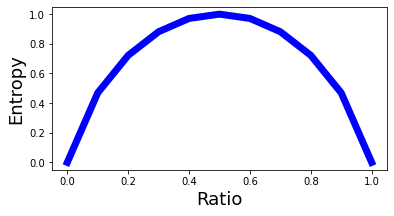

In [210]:
import matplotlib.pyplot as plt

def plot_entropy(N):
    ### YOUR SOLUTION HERE
    ratios = np.array([i / N for i in range(N + 1)])
    entropies = np.array([entropy_given_ratio(ratios[i]) for i in range(N + 1)])
    return ratios, entropies


r, e = plot_entropy(N=10)

plt.figure(figsize=(6,3))

plt.plot(r, e, 'b-', linewidth=7)

plt.xlabel("Ratio", fontsize=18)
plt.ylabel("Entropy", fontsize=18)
plt.show()

## Information gain [3 pts]
There are several metrics we can use to asses how good a split is in a decision tree. For this implemenation we will use the *Information Gain*, which is defined as the entropy of the original distribution $\phi(p)$, minus the entropy of the split distribution $I_m$ resulting from the split on variable $m$.

(3.4a) $$IG_m = \phi(p) - I_m$$

Information Gain measures how much the entropy changes from making a specific split, i.e. the gain in predictablity of the data as a result of making a distribution based on a specific variable. When a set of target labels is split on a variable $m$, two or more new lists are created, each with their own entropy. Combining the resulting entropies from a split into $s$ new sets is a simple weighted sum:

(3.4b) $$I_m = \sum_{j=1}^s \frac{N_j}{N} \phi(p_j)$$

where $N_j$ is the size of the $j^{th}$ split distribution, $p_j$ is the ratio of the target labels for that same $j^{th}$ distribution and $N$ is the size of the distribution before the split. 

Write the function `split_entropy` to compute $I_m$ for some list of target labels and a given `N`. The `split_labels` argument is a list containing $s$ different lists, each containing the target labels for one part of the split.

In [211]:
def split_entropy(split_labels, N):
    ### YOUR SOLUTION HERE
    I = sum([len(split_label) * entropy(split_label) / N for split_label in split_labels])
    return I 

Currently, our function `create_split` returns a dictionary where the keys are the unique entries present in the column chosen and the values are dataframes that contain the rows that have those unique entries. However, the function `split_entropy` expects a list wherein each element is a list of target labels.

Write the function `get_split_labels` that accepts a `split` dictionary and `target` (the name of the column that contains the labels) and returns the `split_labels`. This returned list of lists should be of the same format as before, so it can be used directly as input for the `split_entropy` function.

In [212]:
def get_split_labels(split, target):
    ### YOUR SOLUTION HERE
    split_labels = []
    for entry in split.values():
        split_labels.append(entry[target])
    return split_labels

Write the `information_gain` function using your earlier functions `entropy` and `split_entropy`. Assume `split_labels` is a list containing $s$ different lists, each containing the target labels from one of each  of the splits. Remember that one split exists of all of the grouped unique values in a column of our data, thus, the total number of target labels given to this function is $N$ and the combination of all labels is $p$. You can use `pd.concat` to "glue" the different Series-objects together to compute $p$ directly.

In [213]:
def information_gain(split_labels):
    ### YOUR SOLUTION HERE
    all_data_in_node = pd.concat(split_labels)
    N = len(all_data_in_node)
    return entropy(all_data_in_node) - split_entropy(split_labels, N)

Below, we have created two assertions that check whether your functions were implemented correctly. 

In [214]:
# We create a copy, because we remove the target in create_split, while it is needed for split_labels
test_df = df.copy()
target_copy = target + '_copy'
test_df[target_copy] = test_df[target]

split = create_split(test_df, target_copy)
split_labels = get_split_labels(split, target)

assert entropy(test_df[target].tolist()) == information_gain(split_labels)
assert split_entropy(split_labels, len(test_df)) == 0.0

## ID3

So far, we have determined the total purity of the dataset (entropy), and created the functions that enable us to determine what column of our data is the most informative (Information Gain). That leads us to the introduction of the *ID3* algorithm introduced by Ross Quinlan in 1986. This algorithm can be used to create a categorical decision tree through a process of greedy iterations. Reread table 3.1 in Mitchell's 'Machine Learning', containing the pseudo-code for the algorithm.

Our version of the *ID3* algorithm can be described as follows:

1. *If the current dataset is pure (all rows have the same label), return the pure label.* Use the `unique_value` function for this.
2. *If there are no more possible columns to split; return the most common label.*
3. *Calculate the Information Gain of each possible split in the dataset.* First create splits for each of the columns in the dataset (except for the target column), then extract the label lists for each of these splits and use these to calculate the Information Gain of that split.
4. *Pick the split with the largest Information Gain.*
5. *Create a Node for this new/current branch of the tree.*
6. *For each of the sub-datasets in the split, create a sub-tree (recursively call `ID3` with the sub-dataset) and use the sub-tree result as the branches of the tree created in step 5.*
7. *Return the complete tree.*

We have also provided you with a [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) `Node` that can hold the name of the selected split column; `column_name`, the most common label in this node; `mode`, and a dictionary mapping to results of the split; `branches`, wherein the key is each of the 'unique values' possible, and the values are the result of the algorithm on the data available for that unique value.


In [215]:
from collections import namedtuple

Node = namedtuple('Node', ['column_name',  'mode', 'branches'])

### Example

Lets take a look at an example before we start writing out the complete algorithm. Say we have the following data set and want to classify on the target column *Vegetable*:

|&nbsp;         | Color  | Pits  | Vegetable |
|---------------|--------|-------|-----------|
| **Broccoli**  | Green  | False | True      |
| **Pear**      | Green  | True  | False     |
| **Strawberry**| Red    | False | False     |
| **Zucchini**  | Green  | False | True      |
| **Orange**    | Orange | True  | False     |


We won't bother with computing the exact Information Gain here, but looking at the 2 possible columns and the distribution of the target column *Vegetable*, you might conclude that *Color* would be a good variable to split on.

We can use the [*namedtuple*](https://docs.python.org/3/library/collections.html#collections.namedtuple) to create a `Node` in our Decision Tree and have it store all the relevant information at that level of the tree. The `column_name` to split on has already been chosen to be *Color* and the `mode` is the most common label of the target column in this node, so this would be *False*, as there are currently more fruits than vegetables in our data set. The `branches` would start out by just being the result of the `create_split` function, meaning there would be 3 new data frames, one for each *Color*. The whole `Node` would then look something like 

    Node(column_name='Color', mode=False, branches={
    
            'Green': 

|&nbsp;         | Pits  | Vegetable |
|---------------|-------|-----------|
| **Broccoli**  | False | True      |
| **Pear**      | True  | False     |
| **Zucchini**  | False | True      |

            'Orange':
            
|&nbsp;         | Pits  | Vegetable |
|---------------|-------|-----------|
| **Orange**    | True  | False     |

            'Red':

|&nbsp;         | Pits  | Vegetable |
|---------------|-------|-----------|
| **Strawberry**| False | False     |
            
            })
    
However, this is of course only 1 split of our data. The crucial step in the *ID3* algorithm is step **6**; recursively create the sub-trees. So we want to split each of these data sets again and if those produce new branches, we split those further *again*, etc. This is what creates the actual tree structure, the recursive splitting into nodes, each with new branches.

As you hopefully remember from your first year, all recursions need base cases and that is what steps **1 and 2** are for. The *leaf nodes* are reached when we've already perfectly split the data or no more splits are possible, and in those cases we just return the predicted label. The whole purpose of the tree structure is to predict a label for the target column. So when we reach the end of some path in the Decision Tree, all we really care about is what the predicted target label would be at that leaf in the tree, and so that is the only information we will need to store there.

Combining these steps, *any* branch in a `Node` should always point to another `Node` or the predicted label for that point in the tree. This means the example structure above, containing 3 data frames, would never actually be returned by the algorithm, as the recursive step to split each frame down to *leaf nodes* is still missing. The result of that would look something like

    Node(column='Color', mode=False, branches={
    
        'Green': Node(column='Pits', mode=True, branches={
                
                    False: True, 

                    True: False}),

        'Orange': False,
        
        'Red': False})

Note that each terminal value (i.e. leaf node) is now either *True* or *False*, indicating the predicted label for the *Vegetable* column at that point in the tree. If we try and interpret this tree, there is only 1 case where it would predict that something is indeed a vegetable; when it is both *Green* and has *No Pits*. In all other cases this tree would predict it to be a fruit. Verify both the constructed tree and the resulting interpreted rule before moving on to implementation.

### Implementation [5 pts]

Now that we know what the tree structure will look like, lets build the *ID3* algorithm. So far, we have already included step 5 and 7 for you. Step 5 expects the variables `column_name` and `mode` to already be defined by you, in order to create the `Node`, while the branches start out empty.

Implement the other steps and see if your code produces that same tree on `test_df`, which contains the vegetable example. Note that the *white space* was added to make the example more readable, so your actual result should look like:

    Node(column_name='Color', mode=False, branches={'Green': Node(column_name='Pits', mode=True, branches={False: True, True: False}), 'Orange': False, 'Red': False})

For your convenience we will repeat the steps of the _ID3_ algorithm (this is the same text as you can find above):
1. *If the current dataset is pure (all rows have the same label), return the pure label.* Use the `unique_value` function for this.
2. *If there are no more possible columns to split; return the most common label.* HINT: You can use pandas [`mode()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mode.html).
3. *Calculate the Information Gain of each possible split in the dataset.* First create splits for each of the columns in the dataset (except for the target column), then extract the label lists for each of these splits and use these to calculate the Information Gain of that split.
4. *Pick the split with the largest Information Gain.*
5. *Create a Node for this new/current branch of the tree.*
6. *For each of the sub-datasets in the split, create a sub-tree (recursively call `ID3` with the sub-dataset) and use the sub-tree result as the branches of the tree created in step 5.*
7. *Return the complete tree.*

In [216]:

test_df = pd.DataFrame([['Green', False, True], ['Green', True, False], ['Red', False, False],
                        ['Green', False, True], ['Orange', True, False]],
                       index=['Broccoli', 'Pear', 'Strawberry', 'Zucchini', 'Orange'],
                       columns=['Color', 'Pits', 'Vegetable'])
                       
test_target = 'Vegetable'

def ID3(data, target):    
    # step 1
    ### YOUR SOLUTION HERE
    labels = unique_values(data, target)
    if len(labels) == 1:
        return labels[0]

    # step 2
    ### YOUR SOLUTION HERE
    # check if there's just the target left
    if np.all(data.columns.values == [target]):
        return data[target].mode().values[0]
    
    # step 3
    ### YOUR SOLUTION HERE
    splits = []
    label_lists = []
    entrop = entropy(data[target])
    information_gains = []
    column_names = data.columns.drop(target)
    for idx, column in enumerate(column_names):
        splits.append(create_split(data, column))
        label_lists.append(get_split_labels(splits[idx], target))
        information_gains.append(information_gain(label_lists[idx]))

    # step 4
    ### YOUR SOLUTION HERE
    max_info_gain_idx = np.argmax(information_gain)
    split_attribute = column_names[max_info_gain_idx]

    # step 5
    label_mode = data[target].mode().values[0]
    branches = {}
    tree = Node(column_names[max_info_gain_idx], label_mode, branches)
    
    # step 6
    ### YOUR SOLUTION HERE
    for value, frame in create_split(data, split_attribute).items():
        branches[value] = ID3(frame, target)

    # step 7
    return tree

tree = ID3(test_df, test_target)
print(tree)

Node(column_name='Color', mode=False, branches={'Green': Node(column_name='Pits', mode=True, branches={False: True, True: False}), 'Red': False, 'Orange': False})



Now that we have built a tree, it is important to realise that this algorithm *does not* search the entire space of possible trees for the best possible decision tree, but instead opts for the step at each node that will make the most progress at that moment. The tree that results from these locally optimal choices might not be globally optimal (although that happens to be the case for this small toy example).

## Classify [3 pts]

With this complete tree classifying a new data-entry is pretty easy! Implement the `classify` function, which accepts a tree (a variable containing a `Node` representing the root of the tree), and a *single row* of a DataFrame, i.e. a Series. The function should return the predicted target label for that one row of data.

Continuing the example from before; we have a new element from that same data set, but we don't yet know if it would be considered a vegetable, so we want to try and use our decision tree to predict if it is, e.g.

|&nbsp;         | Color  | Pits  |
|---------------|--------|-------|
| **Tomato**    | Red    | False |

The function should move through the relevant branches down the tree based on the `column_name` at each node and the corresponding value of the row we are trying to predict. There are 3 options at each branch:

1. There is another Node attached to this branch, meaning we should continue further down the tree.
2. This branch leads to a *leaf node*, meaning we now have a predicted label for the row we can return.
3. The value from the column in our row actually does not have corresponding branch in this node. In that case the function should return the most common label in that node.


In [217]:
def classify(tree, row):
    ### YOUR SOLUTION HERE
    if isinstance(tree, Node):
        if row[tree.column_name] in tree.branches.keys():
            return classify(tree.branches[row[tree.column_name]], row)
        return tree.mode
    return tree


test_tomato = pd.Series(['Red', False], index=['Color', 'Pits'])
assert not classify(tree, test_tomato), "Tomato is a fruit!"

test_grape = pd.Series(['Blue', True], index=['Color', 'Pits'])
assert not classify(tree, test_grape), "Grape is a fruit!"

Note that the 3rd option can occur as it is possible the categorical value that is being classified was not present in the training set at that point in the tree. This means that even though there are more branches further down the tree, none of them match the row we are trying to classify. Therefore, the best prediction we can possible give for that row, is simply the most common target label that was present in the training set at that node in the tree.

It could be the case that we have never seen this categorical value in our training set before at all, as with the grape example above. However, it is also possible that a specific categorical value *did* occur in our training set, but still some nodes *do not* have a branch for that value.

## Validation [3 pts]

With all these elements complete, we can start applying the *ID3* algorithm on the heart disease data set and see how well it can predict the *Vascular narrowing* based on the other features describing each patient.

Before we see the accuracy of our Decision Tree, we need to create a validation split. Split the DataFrame into `train` and `test` using a ratio of $0.7$ with [sklearn's `train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [218]:
from sklearn.model_selection import train_test_split

### YOUR SOLUTION HERE
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

We will also need to split the train and test DataFrames into categorical and numerical features, using `cat_num_split`. This could be done manually by taking a good look at the description file ([heart-disease.names](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names)), but it can also be done by counting the amount of unique values present in a column. As an rule of thumb, it is probably unlikely there are more than 10 different categorical values for any one column, while it is seems very likely that there are more than 10 different numerical values for a column present in the data.

Use the `unique_values` function from earlier and select the variables that have no more than the `threshold` argument number of unique values as categorical variables and all others as numerical variables. The categorical variables are all whole numbers, so the resulting 2d-array should be of type `int` and the numeric variables array should of type `float`, for which you can use pandas `astype` method. Remember that both dataframes should have the target column.

Apply this function to separate out the categorical and numerical features for both the training and the test set.

In [219]:
def cat_num_split(data, target, threshold=10):
    ### YOUR SOLUTION HERE
    columns_without_target = data.columns.drop(target)
    cat_attributes = [column for column in columns_without_target if len(unique_values(data, column)) <= threshold]
    num_attributes = data.columns.drop(cat_attributes)
    cat_attributes += [target]
    cat, num = data[cat_attributes].astype(int), data[num_attributes].astype(float)
    return cat, num

train_cat, train_num = cat_num_split(df_train, target)
test_cat, test_num = cat_num_split(df_test, target)

Finally, write the function `validate` that takes a decision tree, a dataframe of testing sample, and the target column name. It should `classify` all rows in the dataframe using the decision tree and return the percentage of elements that was classified correctly. 


Create a decision tree fitted to the categorical training data created above. Validate the results by computing both the train and test accuracy using the categorical features of the heart disease data set.

In [220]:
def validate(tree, data, target):
    ### YOUR SOLUTION HERE
    t = data.apply(lambda x: classify(tree, x), axis=1)
    correctly_classified = sum(data[target].values == t.values)
    all_samples = len(data)
    return correctly_classified / all_samples
        
        
cat_tree = ID3(train_cat, target)
print("Train Accuracy: %.1f%%" %(validate(cat_tree, train_cat, target) * 100))
print("Test Accuracy: %.1f%%" %(validate(cat_tree, test_cat, target) * 100))

Train Accuracy: 95.2%
Test Accuracy: 80.0%


# Numerical Decision Tree [2 pts]

Now that our Categorical Decision Tree is done, we will take a look at a Numerical Decision tree. Start by reading section **3.7.2** from Mitchell. As stated there, it is possible to extend the Categorical Decision Tree to also include numerical boundaries. We could then use this to even select the best Information Gain from *both* the categorical *and* the numerical splits at each node.

However, for now we will focus a model that can *only* make numerical splits, as that is what the `scikit-learn` library provides straight out of the box: The [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) is a class that can build a decision tree from numerical data, and so we won't have to implement this tree from scratch.

The most important difference between categorical and numerical decision trees is the way the data is split. In categorical data, it is easy to split the tree into the $N$ categories that are present in the data. This is impossible to do in numerical data, as there are infinitely many categories. Categorical Decision trees therefore use binary splits or a so called split boundary; where with each split we create one branch with values smaller than the boundary, and one branch with values greater than or equal to the boundary.

This boundary for a column can be determined by trying every possible split boundary available for the set of values. This is done by first sorting the samples and then trying every split half way between two neighbouring values that have different labels. This means there can be as many splits as there are samples, and as such this method is computationally very expensive. An alternative, simpler method that is often used, is trying some amount of random splits for a column and picking the best random split among them.

Note that repeated binary splits on the same numerical variable be used to create many different "decision regions" for the same variable. For example, consider a label where you want a variable to be above or equal to 3.4, but below 4.8. Here you would need two splits; a first split with 3.4 as the boundary and then in the "greater equal branch" of that split, another split boundary of 4.8 on that same variable. This means that while the feature that was split on could be ignored in further splits in the case of a Categorical Decision tree, this is not the case for Numerical Decision Trees, and repeated splits on the same variable can actually greatly improve accuracy.

Implement a Numerical Tree Classifier using a `sklearn.tree.DecisionTreeClassifier` and its `fit` and `predict` functions.  Train it using the numerical part of the dataset you split out earlier, and print the training and test accuracies (this can easily be done through the `metrics.accuracy_score` method from the `metrics` module). Note that the `fit` function of the classifier requires you to separate the target column from the dataframe and provide the training set as `X` and `y`; you can use `.drop(target, axis=1)` for this, as it returns a new dataframe, but without the target class column.  The targets should be passed into the sci-kit functions as integers; you can use `.astype('int')` to cast.

In [221]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

### YOUR SOLUTION HERE
tree = DecisionTreeClassifier()
target = 'num'
data, target_labels = train_num.drop(target, axis=1), train_num[target]
tree.fit(data, target_labels)
train_acc = tree.score(data, target_labels)
target_pred, target_true = tree.predict(test_num.drop(target, axis=1)), test_num[target]
test_acc = metrics.accuracy_score(target_true, target_pred)
print("Train Accuracy: %.1f%%" %(train_acc * 100))
print("Test Accuracy: %.1f%%" %(test_acc * 100))

Train Accuracy: 100.0%
Test Accuracy: 68.9%


The scikit-learn Decision Trees implemenation is specifically intended for numerical features. This might not be immideately obvious, but if we read the documentation on [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) and see what algorithms it uses, we find:

```scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.```

*Note: the linked page on Decision Trees contains more useful information and hints if you plan to use this model on any projects of your own, so it might be worth reading through.*

### Plotting the Decision Tree [1 pt]

Sklearn also comes with a tool that can actually plot the whole decision tree. However, plotting the complete tree would be a bit hard to read, as it wouldn't really fit in the figure. We can again use another `DecisionTreeClassifier` argument to limit the size of the tree. Here using `max_depth` makes the most sense, as we want uniformly cut the tree at certain depth for the plot.  Fit a decision tree of depth 3 (to the numerical categories) and call it `d_tree`. The code to plot the tree has already been provided.

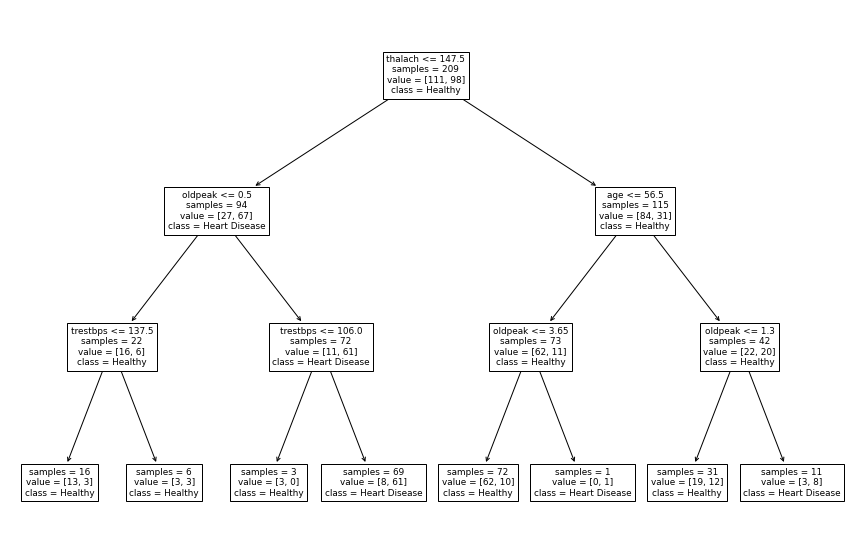

In [222]:
from sklearn import tree
from matplotlib.pyplot import figure

max_depth = 3
### YOUR SOLUTION HERE
d_tree = DecisionTreeClassifier(max_depth=max_depth)
target = 'num'
data, target_labels = train_num.drop(target, axis=1), train_num[target]
d_tree.fit(data, target_labels)

### YOUR SOLUTION ENDS HERE

figure(figsize=(15, 10))
tree.plot_tree(d_tree, feature_names=train_num.columns.values, class_names=['Healthy', 'Heart Disease'], impurity=False);

Read out the boundaries set in the decision tree. Refer back to the [heart-disease.names](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names) if you don't know what a variable means. 

### Which features seem to be the best indicators for heart disease? [1 pt]

**<span style="color:red">(I assume we are talking about the numerical features only) The feature that seems to be the best indicator for heart disease is 'thalach' which is the maximum heart rate achieved. We know that since it is the root of the tree and therefore provides the greatest information gain out of all of the numerical features. That, in other words, means that if we were to decide based on one feature alone, our best choice would be to decide based on 'thalach'.</span>** 

### Depth and Held-Out Accuracy [1 pt]

The depth of the decision tree relates to how expressive a decision function that it can represent: the more branches, the better its ability to carve up the data.  A popular way to prevent overfitting is to limit the depth of the tree (as we did above, for visualization purposes)---making it analogous to the k (complexity parameter) in polynomial regression and k-means.  

Below, make a plot of the relationship between train accuracy, test accuracy, and depth.  Make the max tree depth the x-axis and accuracy the y-axis.  Train a sci-kit learn `DecisionTreeClassifier` on the numerical features for each depth between 1 and 15 (inclusive).  Then plot the train and test accuracy so that you can see how they evolve with depth.

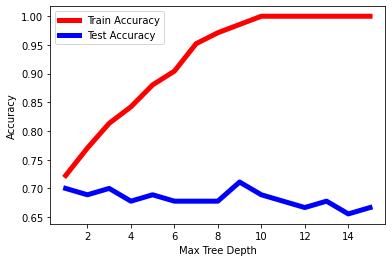

In [223]:
depth_limit = 15
train_accs = []
test_accs = []

### YOUR SOLUTION STARTS HERE
target = 'num'

for x in range(depth_limit):
    tree = DecisionTreeClassifier(max_depth=x + 1)
    data, target_labels = train_num.drop(target, axis=1), train_num[target]
    tree.fit(data, target_labels)
    train_accs.append(tree.score(data, target_labels))
    target_pred, target_true = tree.predict(test_num.drop(target, axis=1)), test_num[target]
    test_accs.append(metrics.accuracy_score(target_true, target_pred))

### YOUR SOLUTION ENDS HERE

plt.figure(figsize=(6,4))

plt.plot([x+1 for x in range(depth_limit)], train_accs, "r-", lw=5, label="Train Accuracy")
plt.plot([x+1 for x in range(depth_limit)], test_accs, "b-", lw=5, label="Test Accuracy")

plt.legend(loc=2)
plt.xlabel("Max Tree Depth")
plt.ylabel("Accuracy")

plt.show()

### How does the accuracy change with depth? [1 pt]

**<span style="color:red">We can see that the training accuracy naturally increases as we allow for greater depth of the tree. That works similarly to the parameter k in regression for example. It works as a bias measure for the model. The lower the k the greater the bias that we introduce on the model. The lower the bias (the higher the depth of the tree) the greater the model's capacity for learning the data. That can in turn lead to overfitting with trees too deep. Our model can start picking up on unimportant features/noise/memorising the data. Hence the test accuracy might decrease as we increase the max depth of the tree too much. In general we can see that in this particular case there is no significant increase (but rather a decrease) in the test accuracy as we increase the max depth of the tree.</span>**